In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
global_path = "/home/julia/Desktop/DIP/lab3"
file_name = "cat"

In [3]:
def plot_array_of_images(values, path_to_write, f):
    fig, axes = plt.subplots(1, len(values))
    for i, value in enumerate(values):
        binary = f(value)
        axes[i].imshow(binary, cmap='gray')
        axes[i].set_title(f"{value}")
        axes[i].set_axis_off()
        cv2.imwrite(f"{global_path}/{path_to_write}/cat_{value}.png", binary)
plt.show()

In [46]:
class ImageAnalyser:
    def __init__(self, path_to_img):
        self.path_to_img = path_to_img
        self.colored_img = self.read()
        # needed as opencv read image in BGR format
        self.convert_from_bgr_to_rgb()
        self.gray_img = self.convert_img_to_gray().astype(np.uint8)

    # read image by path
    def read(self) -> np.ndarray:
        return cv2.imread(self.path_to_img)
    
    def convert_from_bgr_to_rgb(self):
        b, g, r = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        
        rgb_img = np.zeros_like(self.colored_img)
        rgb_img[:, :, 0] = r
        rgb_img[:, :, 1] = g
        rgb_img[:, :, 2] = b
        
        self.colored_img = rgb_img
        
    def convert_from_rgb_to_bgr(self):
        r, g, b = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        
        bgr_img = np.zeros_like(self.colored_img)
        bgr_img[:, :, 0] = b
        bgr_img[:, :, 1] = g
        bgr_img[:, :, 2] = r
        
        return bgr_img
        
    # converts image to grayscale
    def convert_img_to_gray(self) -> np.ndarray:
        r, g, b = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        gray_img = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray_img
    
    def create_hist(self, path_to_save, img=None, hist_name="hist"):
        if img is None:
            img = self.colored_img
        red_dict = {}
        green_dict = {}
        blue_dict = {}
        for i in range(0, 256):
            red_dict[i] = len(np.where(img[:, :, 0] == i)[0])
            green_dict[i] = len(np.where(img[:, :, 1] == i)[0])
            blue_dict[i] = len(np.where(img[:, :, 2] == i)[0])
            
        fig, axes = plt.subplots(1, 3)
        axes[0].bar(red_dict.keys(), red_dict.values(), 1, color='red')
        axes[1].bar(green_dict.keys(), green_dict.values(), 1, color='green')
        axes[2].bar(blue_dict.keys(), blue_dict.values(), 1, color='blue')
        plt.savefig(f"{path_to_save}/{hist_name}.png")

        plt.show()
        
    def log(self, c=1):
        out_img = self.colored_img.astype(float) / 255
        out_img = c * np.log(out_img + 1)
        out_img *= 255
        return out_img.astype(np.uint8)
    
    def gamma_corr(self, gamma, c=1):
        out_img = self.colored_img.astype(float) / 255
        out_img = c * np.power(out_img, gamma)
        out_img *= 255
        return out_img.astype(np.uint8)
    
    def piecewise_linear(self):
        
        out_img = np.zeros_like(self.gray_img)
        
        first_line = np.where(self.gray_img <= 25)
        second_line = np.where((self.gray_img > 25) & (self.gray_img < 45))
        third_line = np.where(self.gray_img >= 45)
        
        out_img[first_line[0], first_line[1]] = self.gray_img[first_line[0], first_line[1]] * 0.4
        out_img[second_line[0], second_line[1]] = (self.gray_img[second_line[0], second_line[1]] * 8.5) - 202.5
        out_img[third_line[0], third_line[1]] = self.gray_img[third_line[0], third_line[1]] * ( 10 / 28) + (4590 / 28)
        
        return out_img
    
    def filter_img(self, kernel_size, func):
        img = self.gray_img.copy()
        left = kernel_size // 2

        if kernel_size % 2 == 0:
            right = left - 1
        else:
            right = left + 1

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i - left >= 0 and i + right < img.shape[0] and j - left >= 0 and j + right < img.shape[1]:        
                    img[i, j] = func(img[i - left : i + right, j - left : j + right])
                else:
                    left_bound_i = i - left
                    right_bound_i = i + right
                    left_bound_j = j - left
                    right_bound_j = j + right
                    if left_bound_i < 0:
                        left_bound_i = i
                    if left_bound_j < 0:
                        left_bound_j = j
                    if right_bound_i >= img.shape[0]:
                        right_bound_i = img.shape[0] - 1
                    if right_bound_j >= img.shape[1]:
                        right_bound_j = img.shape[1] - 1
                                                            
                    img[i, j] = func(img[left_bound_i : right_bound_i, left_bound_j : right_bound_j])

                    
        return img
    
    def mean_filter(self, kernel_size):
        return self.filter_img(kernel_size, np.mean)
        
    def median_filter(self, kernel_size):
        return self.filter_img(kernel_size, np.median)

image_analyser = ImageAnalyser(f"{global_path}/{file_name}.jpg")

### 1
Create hist of image

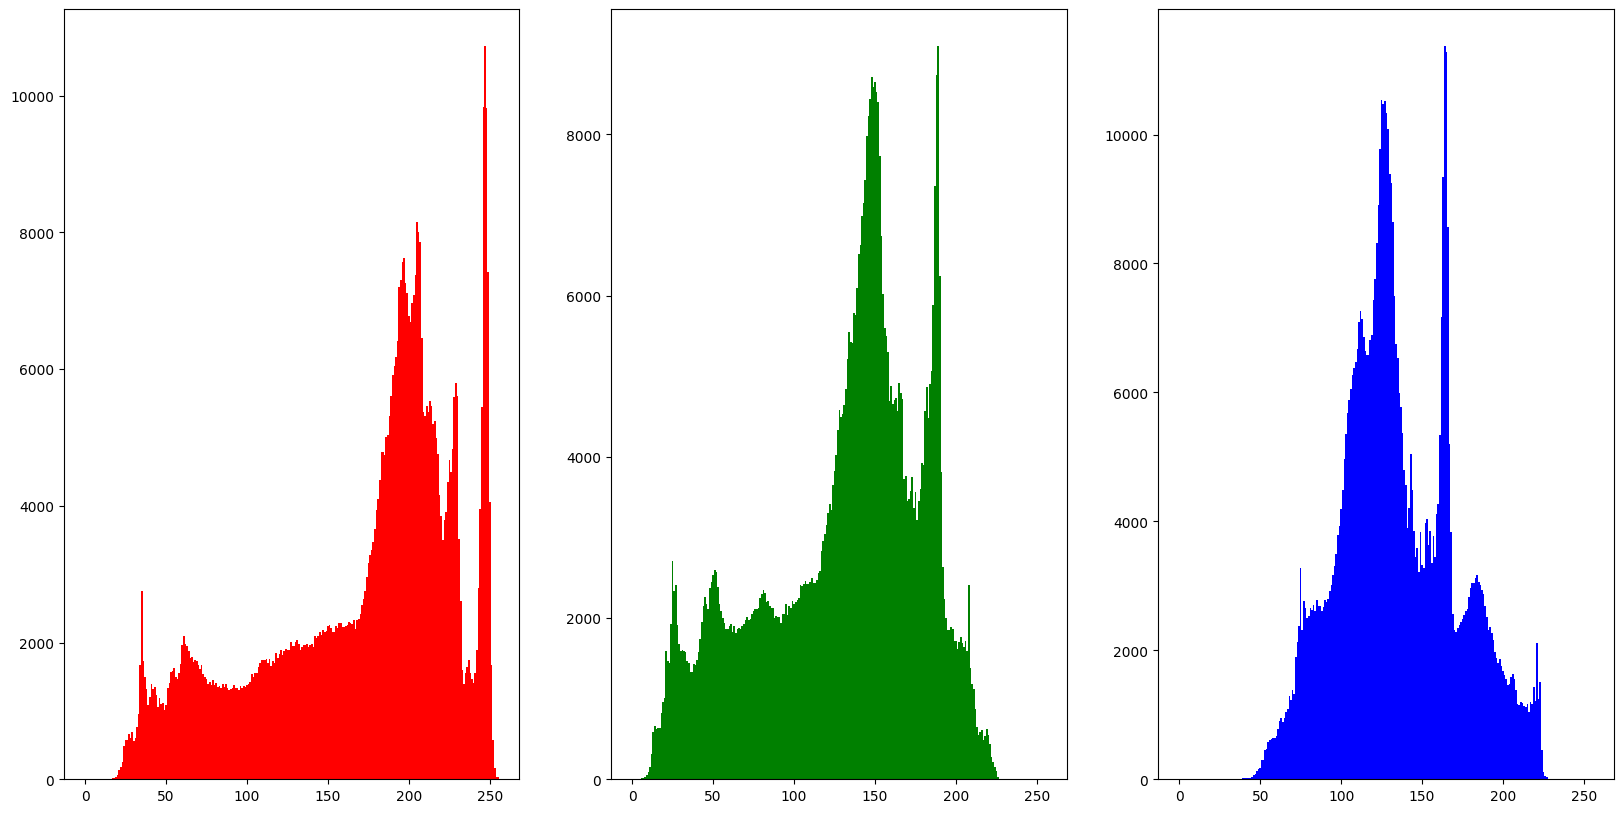

In [5]:
image_analyser.create_hist("/home/julia/Desktop/DIP/lab3")

### 2
Log image

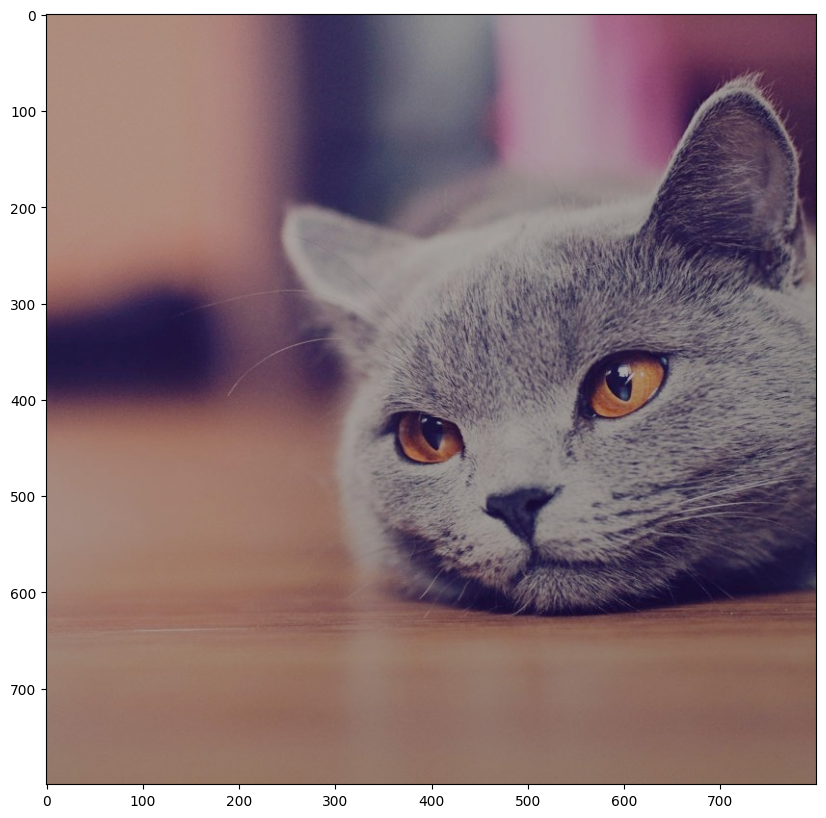

In [6]:
log_img = image_analyser.log()

plt.imshow(log_img)
plt.show()

### 3
Gamma correction

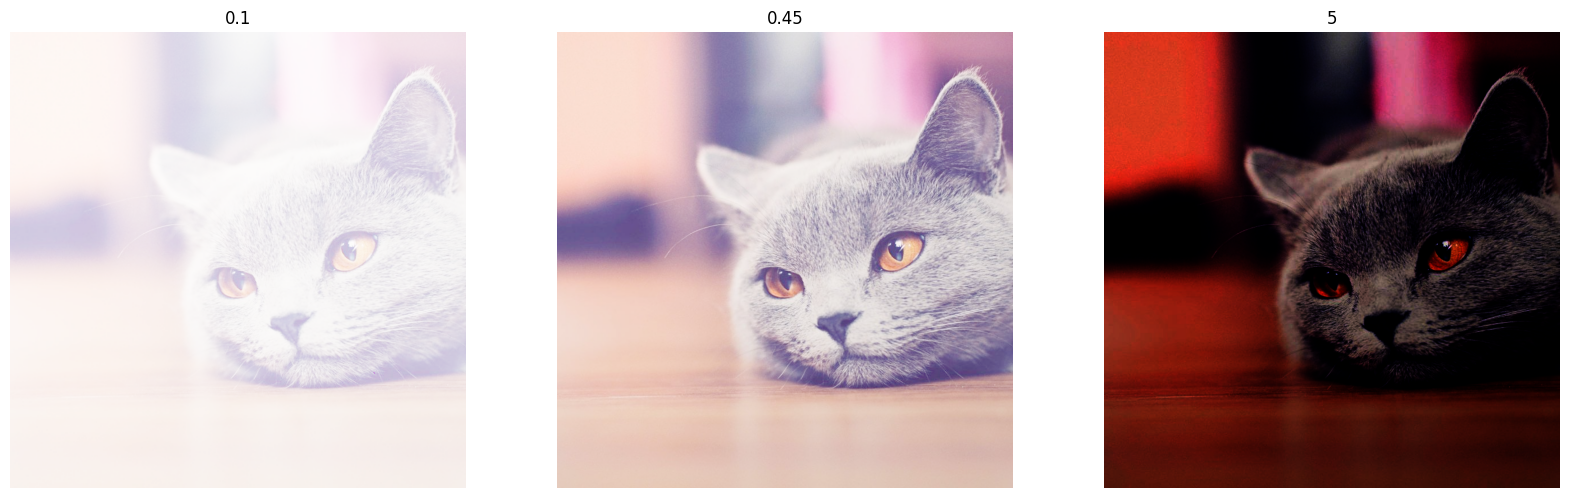

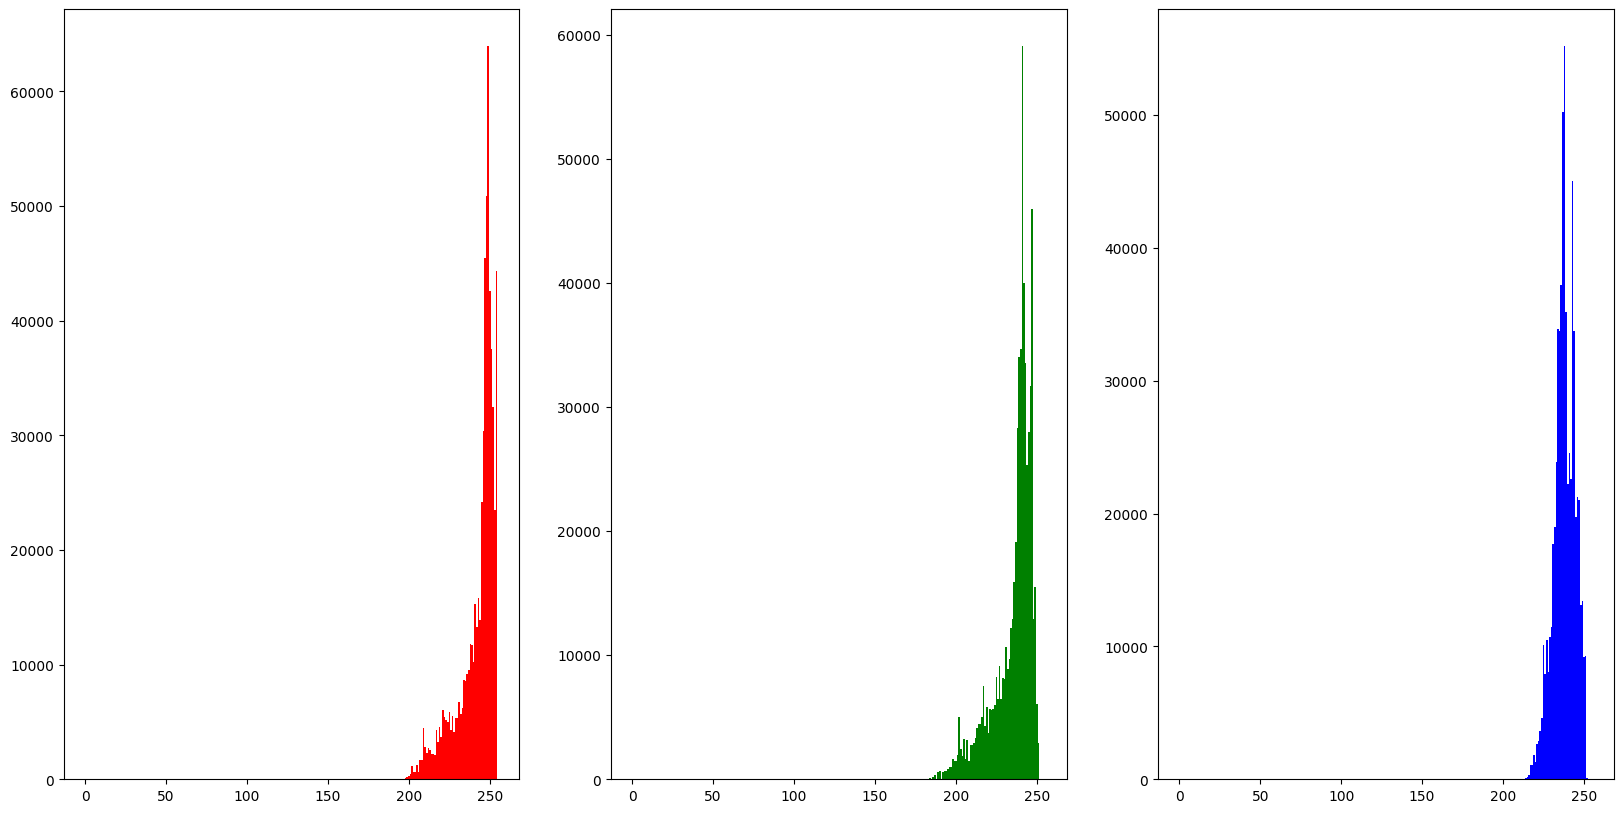

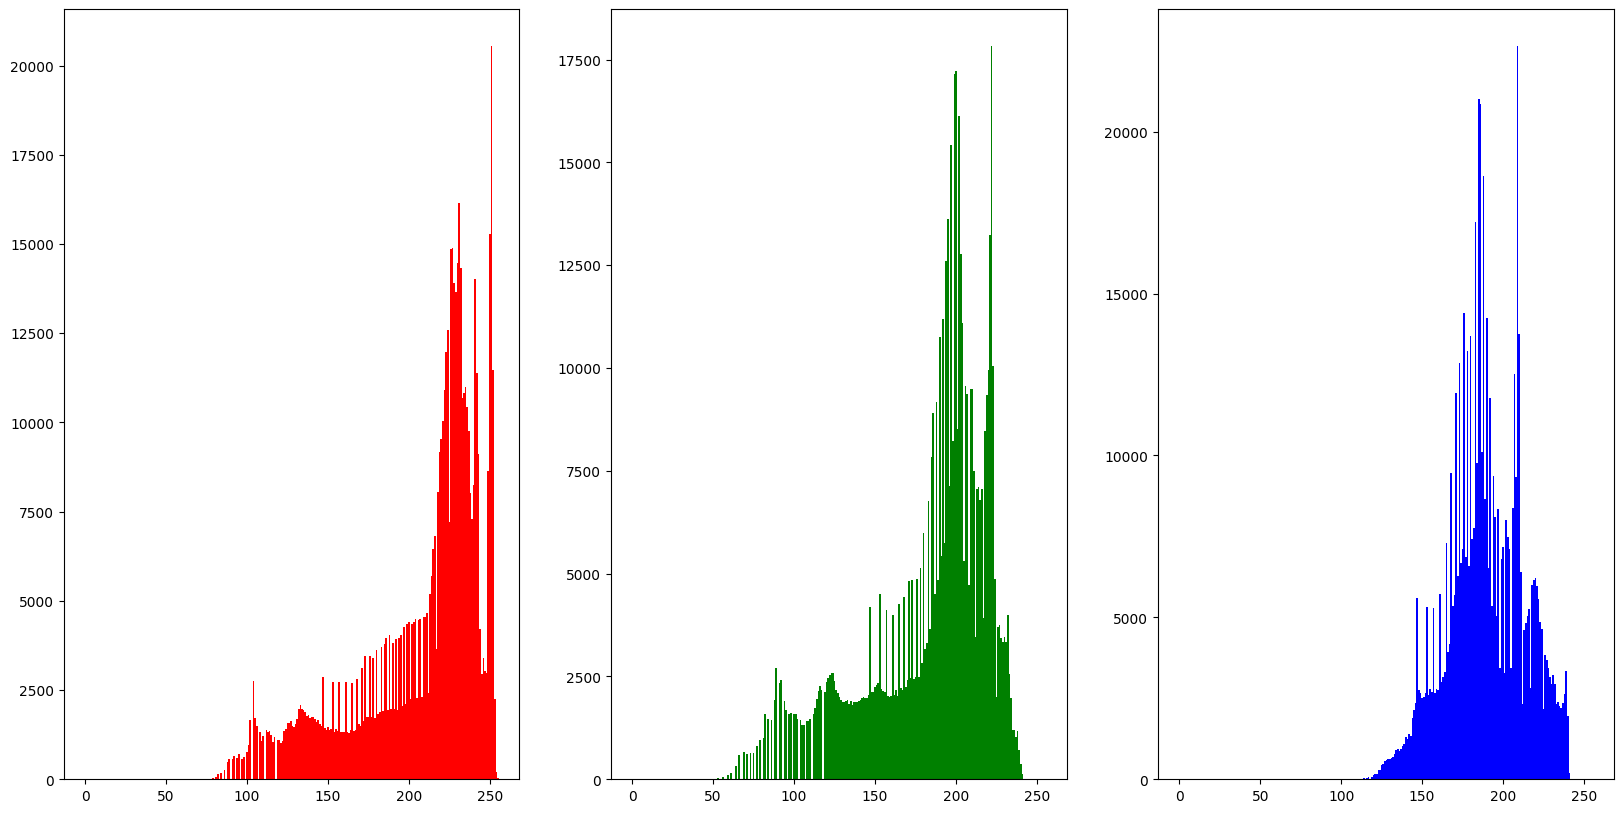

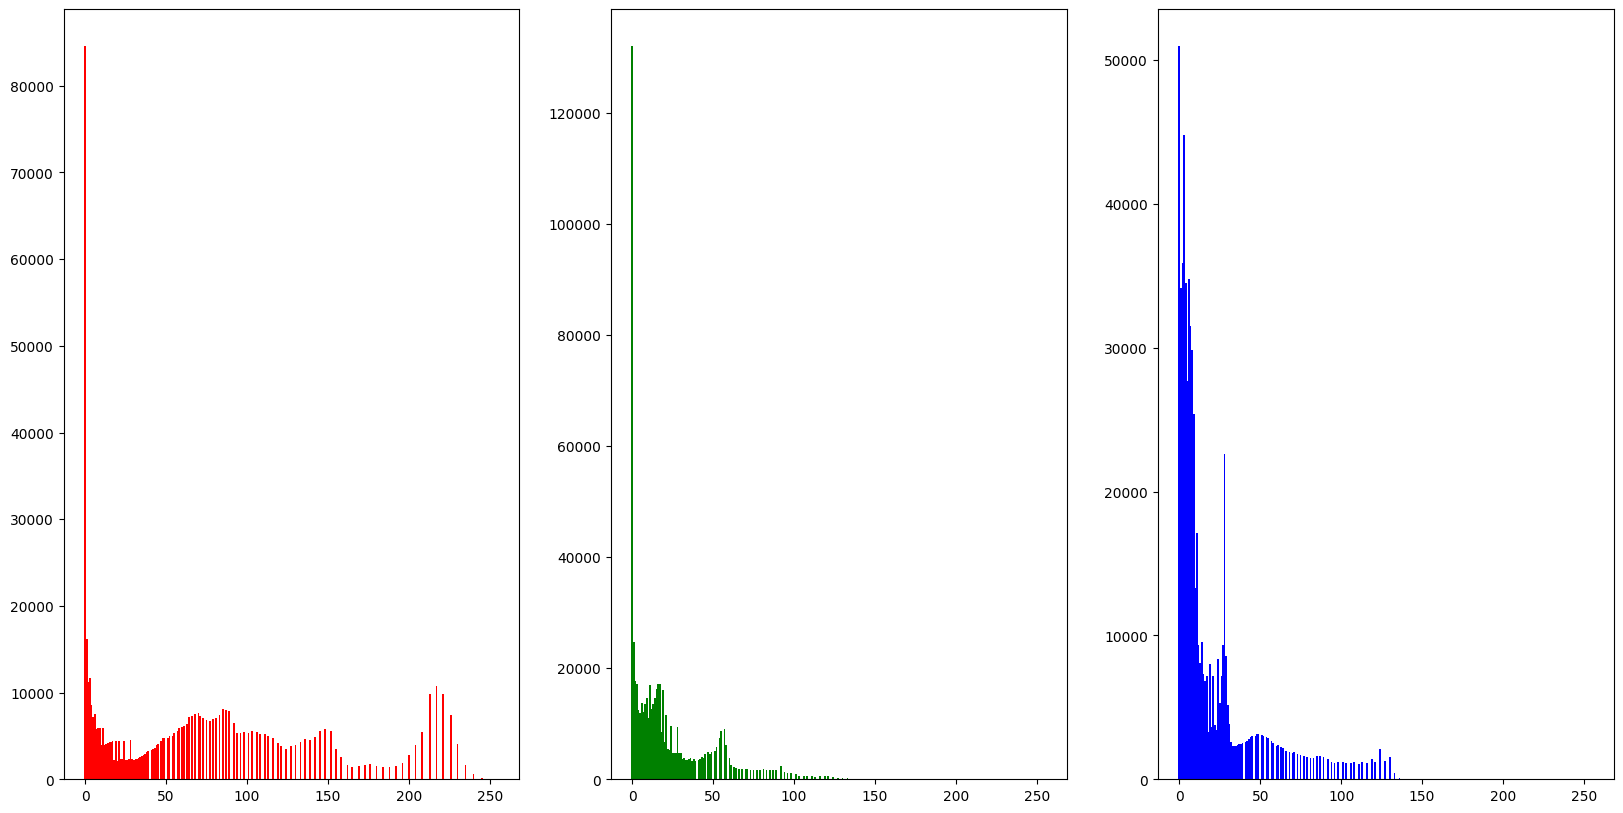

In [7]:
gammas = [0.1, 0.45, 5]

plot_array_of_images(gammas, "Degree", image_analyser.gamma_corr)

for gamma in gammas:
    image_analyser.create_hist("/home/julia/Desktop/DIP/lab3/Degree", image_analyser.gamma_corr(gamma), f"hist_{gamma}")

Check that formula is ok

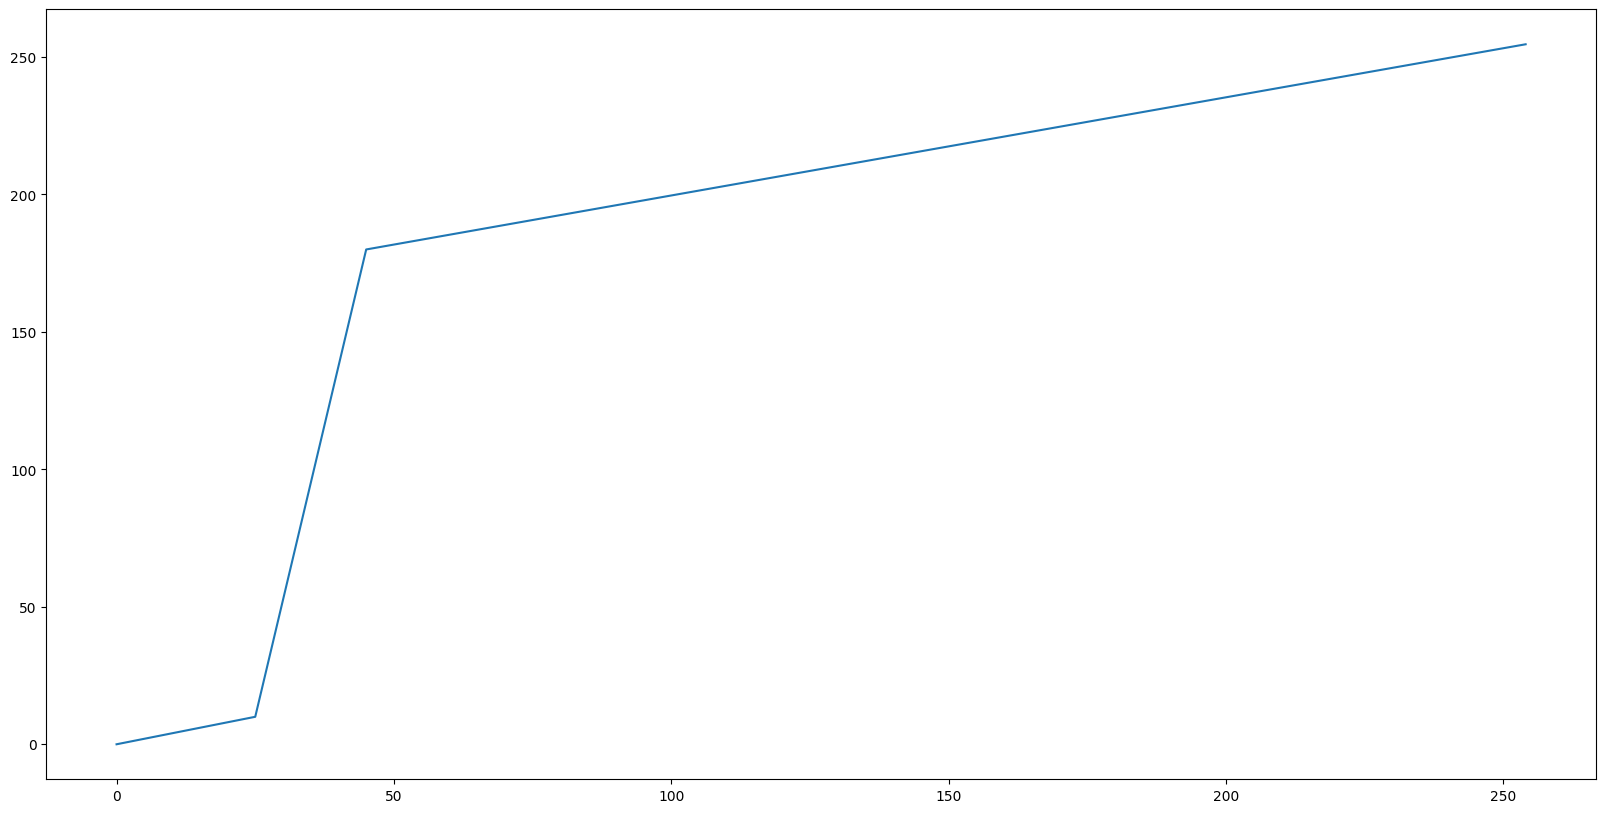

In [8]:
def eq(brightness):
    if brightness <= 25:
        brightness *= 0.4
    elif 25 <= brightness < 45:
        brightness *= 8.5
        brightness -= 202.5
    else:
        brightness  = (4590 / 28 + brightness * 10 / 28)
    return brightness

arr = []
for i in range(0, 255):
    arr.append(eq(i))
    
plt.plot(arr)

### 4
Piecewise linear transformation

First var

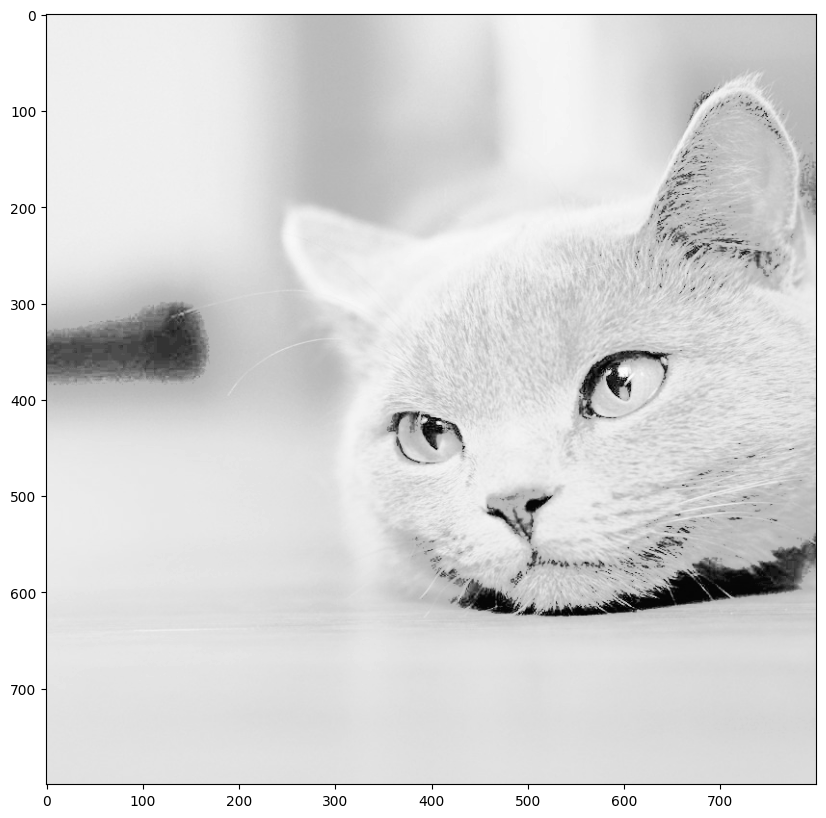

In [9]:
out = image_analyser.piecewise_linear()
plt.imshow(out, cmap="gray")
plt.show()

### 6
Mean filter

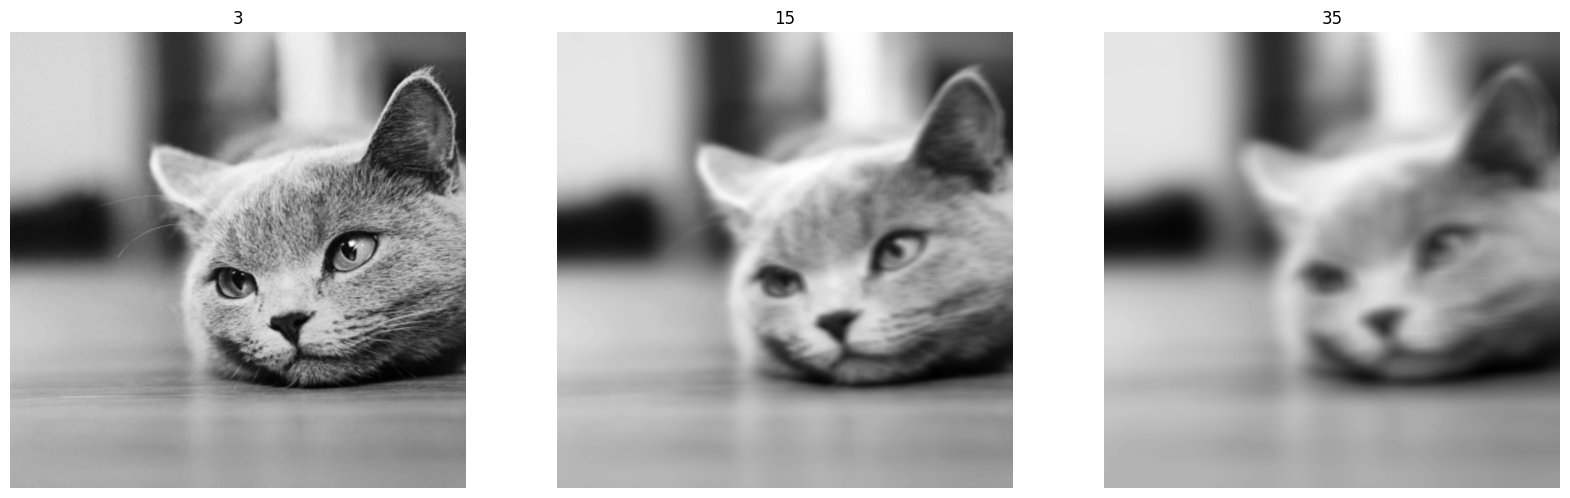

In [49]:
kernels = [3, 15, 35]
plot_array_of_images(kernels, "Filter", image_analyser.mean_filter)

### 8
Median filter

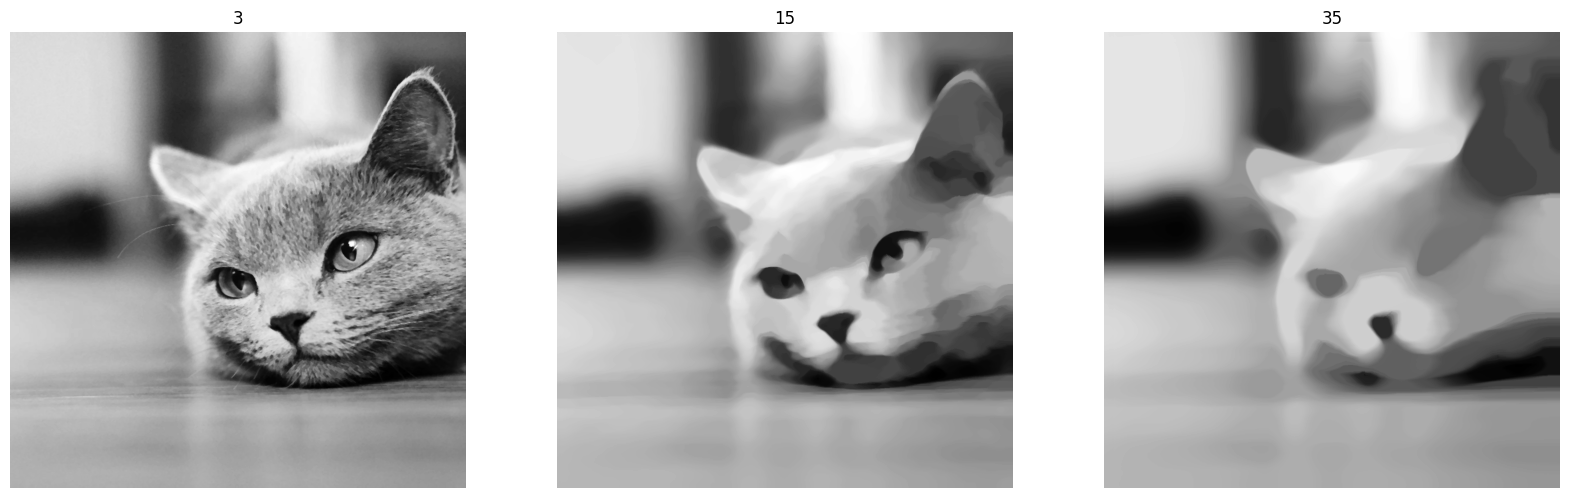

In [48]:
kernels = [3, 15, 35]
plot_array_of_images(kernels, "Median", image_analyser.median_filter)